# Building a simple NN from scratch with numPy

Implement the missing functionalities one by one.

In [1]:
from os.path import join
import random

import numpy as np

from dreader import MnistDataloader, show_images


## Data Import (Given)

We use the MNIST dataset, it contains 28x28 images of handwritten digits, we want to classify. The training data contains 60k images, the test dataset contains 10k.

In [2]:
DATA_PATH = "./dataset/"

# paths
training_images_filepath = join(
    DATA_PATH, "train-images.idx3-ubyte"
)
training_labels_filepath = join(
    DATA_PATH, "train-labels.idx1-ubyte"
)
test_images_filepath = join(DATA_PATH, "t10k-images.idx3-ubyte")
test_labels_filepath = join(DATA_PATH, "t10k-labels.idx1-ubyte")

mnist_dataloader = MnistDataloader(
    training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath,
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

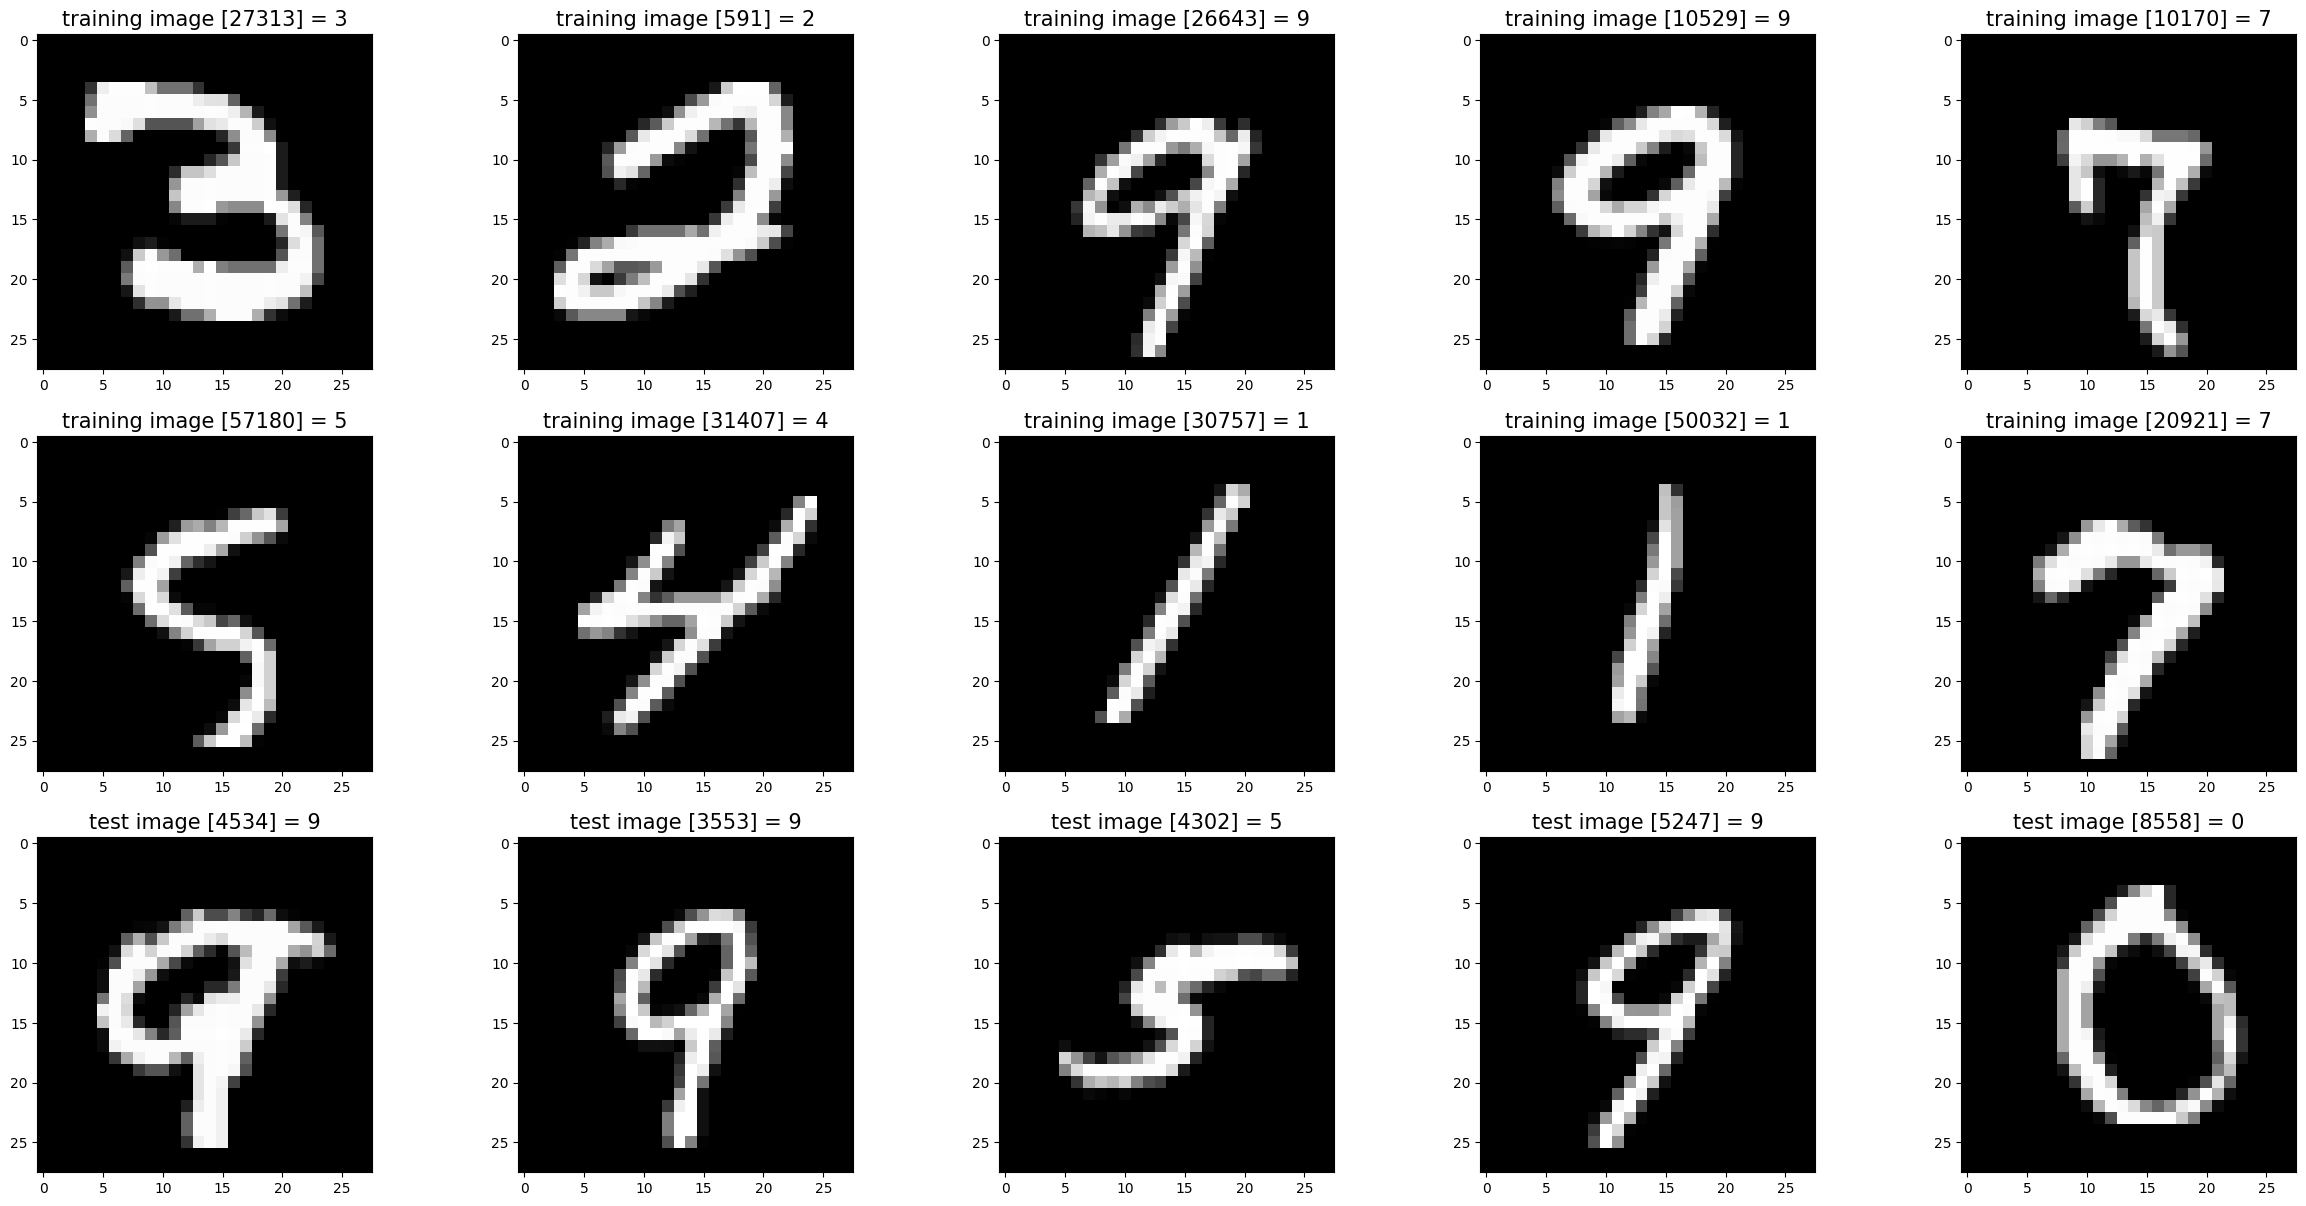

In [3]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append("training image [" + str(r) + "] = " + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append("test image [" + str(r) + "] = " + str(y_test[r]))

show_images(images_2_show, titles_2_show)

## Transform Data for Numpy

In [4]:
# TBD: convert data into numpy arrays and normalize values between to 0-1 (currently its 0-255) (x = image array, y = label)
TRAINING_SIZE = 60000  # max 60000

x_train = np.array(x_train[:TRAINING_SIZE])/255
y_train = np.array(y_train[:TRAINING_SIZE])   

x_test = np.array(x_test)/255
y_test = np.array(y_test)

# transform the data into 2D arrays with 28*28=784 pixels
input_size = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], input_size)
x_test = x_test.reshape(x_test.shape[0], input_size)

x_train.shape

(60000, 784)

## Setup the Network

Complete the function init_params to return the arrays, defining the tunable parameters (weights W, biases b per layer).
We will build a network with two trainable layers of size 10 each. What is the size of the input layer?

In [5]:
def init_params():
    W1 = np.random.rand(10,input_size) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## The Activation Functions

The activation functions are crucial for learning more complex patterns as they break up the currently linear flow by introducing non-linearity.

Set up a relu function (takes an np.array as an input and outputs an np.array where each val is the output of the relu).
Set up a softmax function for the output layer.

In [6]:
def relu(x):
    return np.maximum(0,x)


def softmax(x):
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=0)

## Forward Propagation

Now we want to implement the forward pass through the network. Simply calculating the next layers values by Wx + b first, and adding the activation function next. Output the vals before each activation function (Z1, Z2) and after the relu and the softmax (A1, A2).

Using the dot product of the weights with the previous input x and adding the bias b computes the value all at once, before the activation function.

In [7]:
def forward_prop(W1, b1, W2, b2, x):
    Z1 = W1.dot(x) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

## Calculate the error by Backpropagation

This is the core function for learning. After the forward pass, we compare the difference between the expected result in one hot (e.g. 0 1 0... for label 2) and the output layer. This gives us dZ2, the error in layer 2 (the output layer). Calculate dW2, db2, dZ1, dW1 and db1 accordingly.

In [8]:
# helper
def one_hot(y):
    one_hot_y = np.zeros(
        (y.size, y.max() + 1)
    )  # create a matrix of y.size rows and y.max()+1 (10) columns
    one_hot_y[np.arange(y.size), y] = (
        1  # set the value of the column at the index of y to 1
    )
    one_hot_y = (
        one_hot_y.T
    )  # transpose the matrix bc we want each column to be an example

    return one_hot_y

In [9]:
def deriv_relu(x):
    return x > 0


def back_prop(Z1, A1, Z2, A2, W1, W2, x, y):
    dZ2 = (A2-one_hot(y)) # cross entropy
    dW2 = 1/TRAINING_SIZE * dZ2 @ A1.T #
    db2 = 1/TRAINING_SIZE * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T @ dZ2 * deriv_relu(Z1)
    dW1 = 1/TRAINING_SIZE * dZ1 @ x.T #
    db1 = 1/TRAINING_SIZE * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2


## Update the parameters by the errors calculated through Backprop

Nudge each value by the calculated error (d..) times the learning rate and subtract this from the previous value.

In [10]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha*dW1
    b1 = b1 - alpha*db1
    W2 = W2 - alpha*dW2
    b2 = b2 - alpha*db2

    return W1, b1, W2, b2

## Accuracy and loss function

Used to get insights into training progress.

In [11]:
def get_predictions(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(A2, y):
    predictions = get_predictions(A2)
    return np.mean(predictions == y)


def get_loss(A2, y):
    one_hot_y = one_hot(y)
    return -np.sum(one_hot_y * np.log(A2 + 1e-8)) / TRAINING_SIZE

## Implement learning algorithm (gradient descent)

In [12]:
def gradient_descent(x: np.ndarray, y, iters, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iters):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, x.T)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, x.T, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i%10==0:
            print(f"Iteration: {i}")
            print(f"Accuracy: {get_accuracy(A2, y)}")
            print(f"Loss: {get_loss(A2, y)}")
        
        
    return W1, b1, W2, b2

# Start training

In [13]:
W1, b1, W2, b2 = gradient_descent(x_train, y_train, 1000, 0.8)

Iteration: 0
Accuracy: 0.13118333333333335
Loss: 3.0046217786489433
Iteration: 10
Accuracy: 0.38695
Loss: 1.721912134044731
Iteration: 20
Accuracy: 0.5897333333333333
Loss: 1.1617380766292058
Iteration: 30
Accuracy: 0.6697333333333333
Loss: 0.9783425968532256
Iteration: 40
Accuracy: 0.66865
Loss: 0.9647182266392836
Iteration: 50
Accuracy: 0.6869
Loss: 0.9619798858363781
Iteration: 60
Accuracy: 0.7214666666666667
Loss: 0.8459315500623644
Iteration: 70
Accuracy: 0.77935
Loss: 0.664752362792006
Iteration: 80
Accuracy: 0.8064833333333333
Loss: 0.6025731111975002
Iteration: 90
Accuracy: 0.7973666666666667
Loss: 0.6238798032659699
Iteration: 100
Accuracy: 0.8157666666666666
Loss: 0.5754770782155252
Iteration: 110
Accuracy: 0.8299333333333333
Loss: 0.5355975836837116
Iteration: 120
Accuracy: 0.8416166666666667
Loss: 0.5080920331245214
Iteration: 130
Accuracy: 0.8433333333333334
Loss: 0.5036895003067395
Iteration: 140
Accuracy: 0.8531166666666666
Loss: 0.4751440641690199
Iteration: 150
Accurac

## Test the model

In [14]:
Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, x_test.T)
predictions = get_predictions(A2)

print("Test accuracy: ", get_accuracy(A2, y_test))
print("Test loss: ", get_loss(A2, y_test))
print("Predictions: ", predictions)
print("True values: ", y_test)

Test accuracy:  0.9108
Test loss:  0.05125821988589784
Predictions:  [7 2 1 ... 4 5 6]
True values:  [7 2 1 ... 4 5 6]


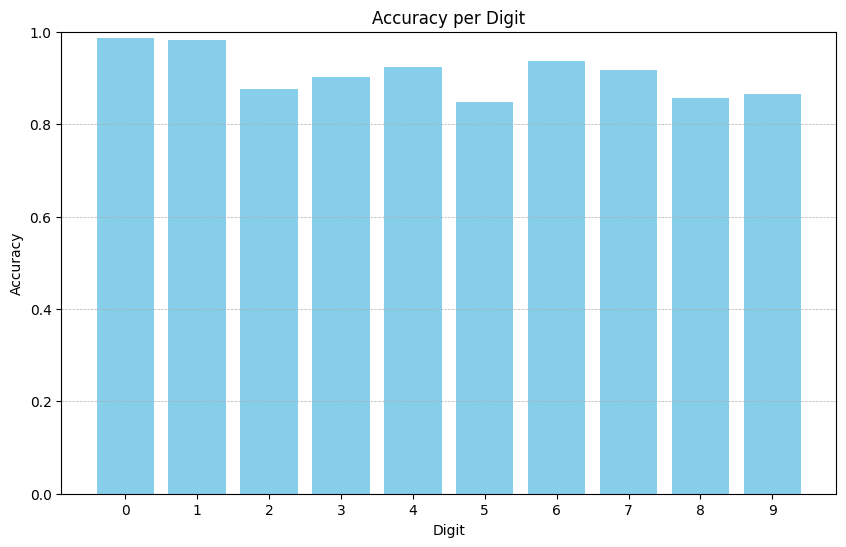

In [15]:
import matplotlib.pyplot as plt

classes = np.unique(y_test)
accuracy_per_class = {}

for cls in classes:
    idx = (y_test == cls)
    cls_accuracy = np.mean(predictions[idx] == y_test[idx])
    accuracy_per_class[cls] = cls_accuracy

# Plotting accuracy per digit
plt.figure(figsize=(10,6))
plt.bar(accuracy_per_class.keys(), accuracy_per_class.values(), color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy per Digit')
plt.xticks(classes)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

## Store the model

In [16]:
STORE = True

import numpy as np

def save_model(W1, b1, W2, b2, path):
    np.savez(path, W1=W1, b1=b1, W2=W2, b2=b2)
    print(f"Model saved to {path}")

def load_model(path):
    data = np.load(path)
    W1 = data['W1']
    b1 = data['b1']
    W2 = data['W2']
    b2 = data['b2']
    print(f"Model loaded from {path}")
    return W1, b1, W2, b2

# Specify the path where you want to save the model
MODEL_PATH = DATA_PATH + 'model_parameters.npz' 

if STORE:
    # Save the model parameters
    save_model(W1, b1, W2, b2, MODEL_PATH)


Model saved to ./data/mnist/model_parameters.npz


In [17]:
W1_loaded, b1_loaded, W2_loaded, b2_loaded = load_model(MODEL_PATH)

# Use the loaded model to perform forward propagation on test data
Z1, A1, Z2, A2 = forward_prop(W1_loaded, b1_loaded, W2_loaded, b2_loaded, x_test.T)
print("Test accuracy after loading model:", get_accuracy(A2, y_test))

Model loaded from ./data/mnist/model_parameters.npz
Test accuracy after loading model: 0.9108
